In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# print not using scientific notation
np.set_printoptions(suppress=True)

%matplotlib inline

In [15]:
def create_transformation_matrix(xyz, quat):
    """
    Create a 4x4 transformation matrix from position (x, y, z) and quaternion (qx, qy, qz, qw).
    """
    # Convert quaternion to rotation matrix using scipy
    rotation = R.from_quat(quat)
    rotation_matrix = rotation.as_matrix()  # 3x3 rotation matrix

    # Create 4x4 transformation matrix
    transformation_matrix = np.eye(4)  # Start with an identity matrix
    transformation_matrix[:3, :3] = rotation_matrix  # Set the top-left 3x3 block to the rotation matrix
    transformation_matrix[:3, 3] = xyz  # Set the translation vector

    return transformation_matrix

In [3]:
traj_id = "z1_rs_calib_lab_2025-01-22-08-19-38"

In [57]:
orb_trajs = np.loadtxt("/mnt/ldata/data/temp/spi_postproc/"+ traj_id +"/CameraTrajectory.txt")
orb_time_stamps = np.loadtxt("/mnt/ldata/data/temp/spi_postproc/"+ traj_id +"/times.txt")
orb_trajs = orb_trajs.reshape(-1, 3, 4)

end_rows = np.zeros((orb_trajs.shape[0], 1, 4))
end_rows[:, 0, 3] = 1
orb_trajs = np.concatenate((orb_trajs, end_rows), axis=1)

print("orb_trajs: ", orb_trajs.shape)
print("orb_time_stamps: ", orb_time_stamps.shape)   
# f << setprecision(9) << Rwc(0,0) << " " << Rwc(0,1)  << " " << Rwc(0,2) << " "  << twc(0) << " " <<
#         Rwc(1,0) << " " << Rwc(1,1)  << " " << Rwc(1,2) << " "  << twc(1) << " " <<
#         Rwc(2,0) << " " << Rwc(2,1)  << " " << Rwc(2,2) << " "  << twc(2) << endl;


orb_trajs:  (1367, 4, 4)
orb_time_stamps:  (1367,)


In [19]:
gt_trajs = np.loadtxt("/mnt/ldata/data/temp/spi_postproc/"+ traj_id +"/OpticalEndPoseRobotArmCalc.txt", delimiter=",")
# gt_trajs is a list of [time, x, y, z, qx, qy, qz, qw]
# convert to 4x4 transformation matrix
gt_tranjs_mat = np.zeros((gt_trajs.shape[0], 4, 4))
for i in range(gt_trajs.shape[0]):
    xyz = gt_trajs[i, 1:4]
    quat = gt_trajs[i, 4:]
    gt_tranjs_mat[i] = create_transformation_matrix(xyz, quat)
gt_time_stamps = gt_trajs[:, 0]

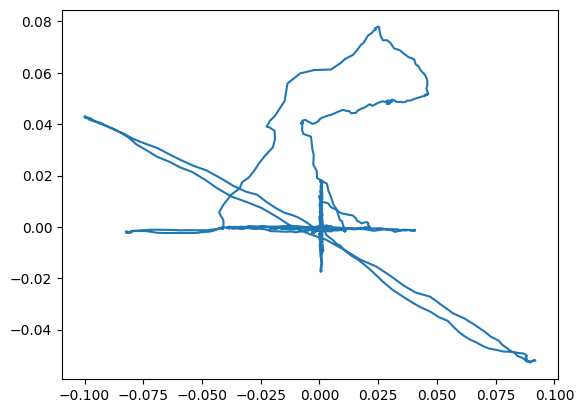

In [24]:
plt.plot(orb_trajs[:, 0, 3], orb_trajs[:, 1, 3], label="orb")

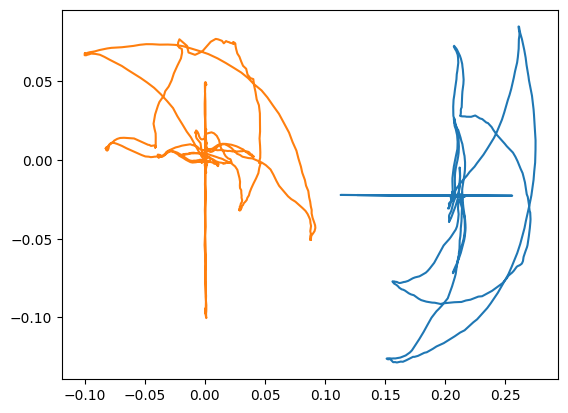

In [41]:
plt.plot(gt_tranjs_mat[:, 0, 3], gt_tranjs_mat[:, 1, 3], label="gt")
plt.plot(orb_trajs[:, 0, 3], orb_trajs[:, 2, 3], label="orb")

In [39]:
init_trans = gt_tranjs_mat[0]

init_trans_inv = np.linalg.inv(init_trans)

gt_tranjs_mat_from_inits =[]
for i in range(gt_tranjs_mat.shape[0]):
    gt_tranjs_mat_from_init = init_trans_inv.dot(gt_tranjs_mat[i])
    gt_tranjs_mat_from_inits.append(gt_tranjs_mat_from_init)
gt_tranjs_mat_from_inits = np.array(gt_tranjs_mat_from_inits)


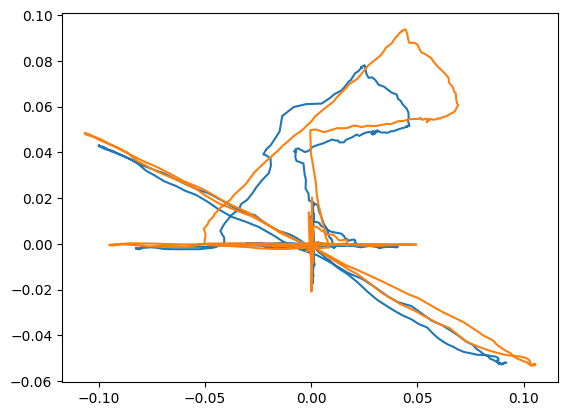

In [64]:
plt.plot(orb_trajs[:, 0, 3], orb_trajs[:, 1, 3], label="orb")
plt.plot(gt_tranjs_mat_from_inits[:, 0, 3], gt_tranjs_mat_from_inits[:, 1, 3], label="gt")


In [69]:
# sync two trajectories
print("orb_time_stamps: ", orb_time_stamps.shape)
print("gt_time_stamps: ", gt_time_stamps.shape)

# for each orb timestamp, find the closest gt timestamp
gt_indices = []
for i in range(orb_time_stamps.shape[0]):
    orb_time = orb_time_stamps[i]
    gt_index = np.argmin(np.abs(gt_time_stamps - orb_time))
    gt_indices.append(gt_index)

gt_tranjs_mat_from_inits_synced = gt_tranjs_mat_from_inits[gt_indices]
print("gt_tranjs_mat_from_inits_synced: ", gt_tranjs_mat_from_inits_synced.shape)

orb_time_stamps:  (1367,)
gt_time_stamps:  (1395,)
gt_tranjs_mat_from_inits_synced:  (1367, 4, 4)


In [86]:
# save orb and gt trajectories to kitti format 12 numbers per line
with open("/mnt/ldata/data/temp/spi_postproc/" + traj_id + "/evo_orb.txt", "w") as f:
    for i in range(orb_trajs.shape[0]):
        for row in range(3):
            for col in range(4):
                f.write(str(orb_trajs[i, row, col]))
                if row < 2 or col < 3:  # Add space only if it's not the last number
                    f.write(" ")
        f.write("\n")

with open("/mnt/ldata/data/temp/spi_postproc/" + traj_id + "/evo_gt.txt", "w") as f:
    for i in range(gt_tranjs_mat_from_inits_synced.shape[0]):
        for row in range(3):
            for col in range(4):
                f.write(str(gt_tranjs_mat_from_inits_synced[i, row, col]))
                if row < 2 or col < 3:  # Add space only if it's not the last number
                    f.write(" ")
        f.write("\n")

In [83]:
orb_trajs[1]
# format a array of #  << Rwc(0,0) << " " << Rwc(0,1)  << " " << Rwc(0,2) << " "  << twc(0) << " " <<
#         Rwc(1,0) << " " << Rwc(1,1)  << " " << Rwc(1,2) << " "  << twc(1) << " " <<
#         Rwc(2,0) << " " << Rwc(2,1)  << " " << Rwc(2,2) << " "  << twc(2) <<;
lin = []
for row in range(3):
    for col in range(4):
        lin.append(orb_trajs[1, row, col])
print(lin)
np.array(lin).reshape(3, 4)

[0.999995649, 0.001194802, -0.002697461, -2.1491e-05, -0.001193931, 0.999999225, 0.000324459, 3.244e-06, 0.002697846, -0.000321237, 0.999996305, -0.000108419]


array([[ 0.99999565,  0.0011948 , -0.00269746, -0.00002149],
       [-0.00119393,  0.99999923,  0.00032446,  0.00000324],
       [ 0.00269785, -0.00032124,  0.99999631, -0.00010842]])

In [84]:
orb_trajs[1]


array([[ 0.99999565,  0.0011948 , -0.00269746, -0.00002149],
       [-0.00119393,  0.99999923,  0.00032446,  0.00000324],
       [ 0.00269785, -0.00032124,  0.99999631, -0.00010842],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

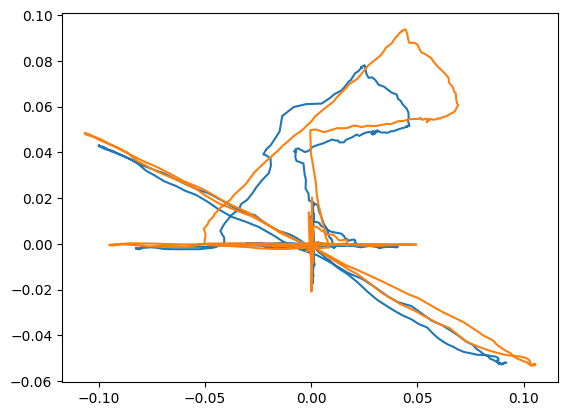